In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 8]
plt.style.use('ggplot')

# Intro

The following is the formula for the binomial distribution which  is the likelihood for the globe tossing model.

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$

In [2]:
from scipy.stats import binom
N = 9
p = 0.5

binom.stats(N, p, moments='mvsk')

(array(4.5), array(2.25), array(0.), array(-0.22222222))

The 'mvsk' stands for 'mean', 'variance', 'skewness' and 'kurtosis'.

In [3]:
binom.pmf(6, N, p)

0.16406250000000006

This is the probability of observing 6 Water in 9 sample assuming the probability of observing water is 0.5. `pmf` is equivalent to the `d`dist functions in R.

In [4]:
binom.pmf([1, 2, 3], N, p)

array([0.01757812, 0.0703125 , 0.1640625 ])

# Posterior Estimation via grid approximation

The idea of grid approximation is to sample the parameter space and then compute the posterior at each value. However, this becomes computationally infeasible as the number of parameter increases.

In [5]:
from src.base import BinomialGridApproximator

In [6]:
X = 6
N = 9
GRID_SIZE = 100

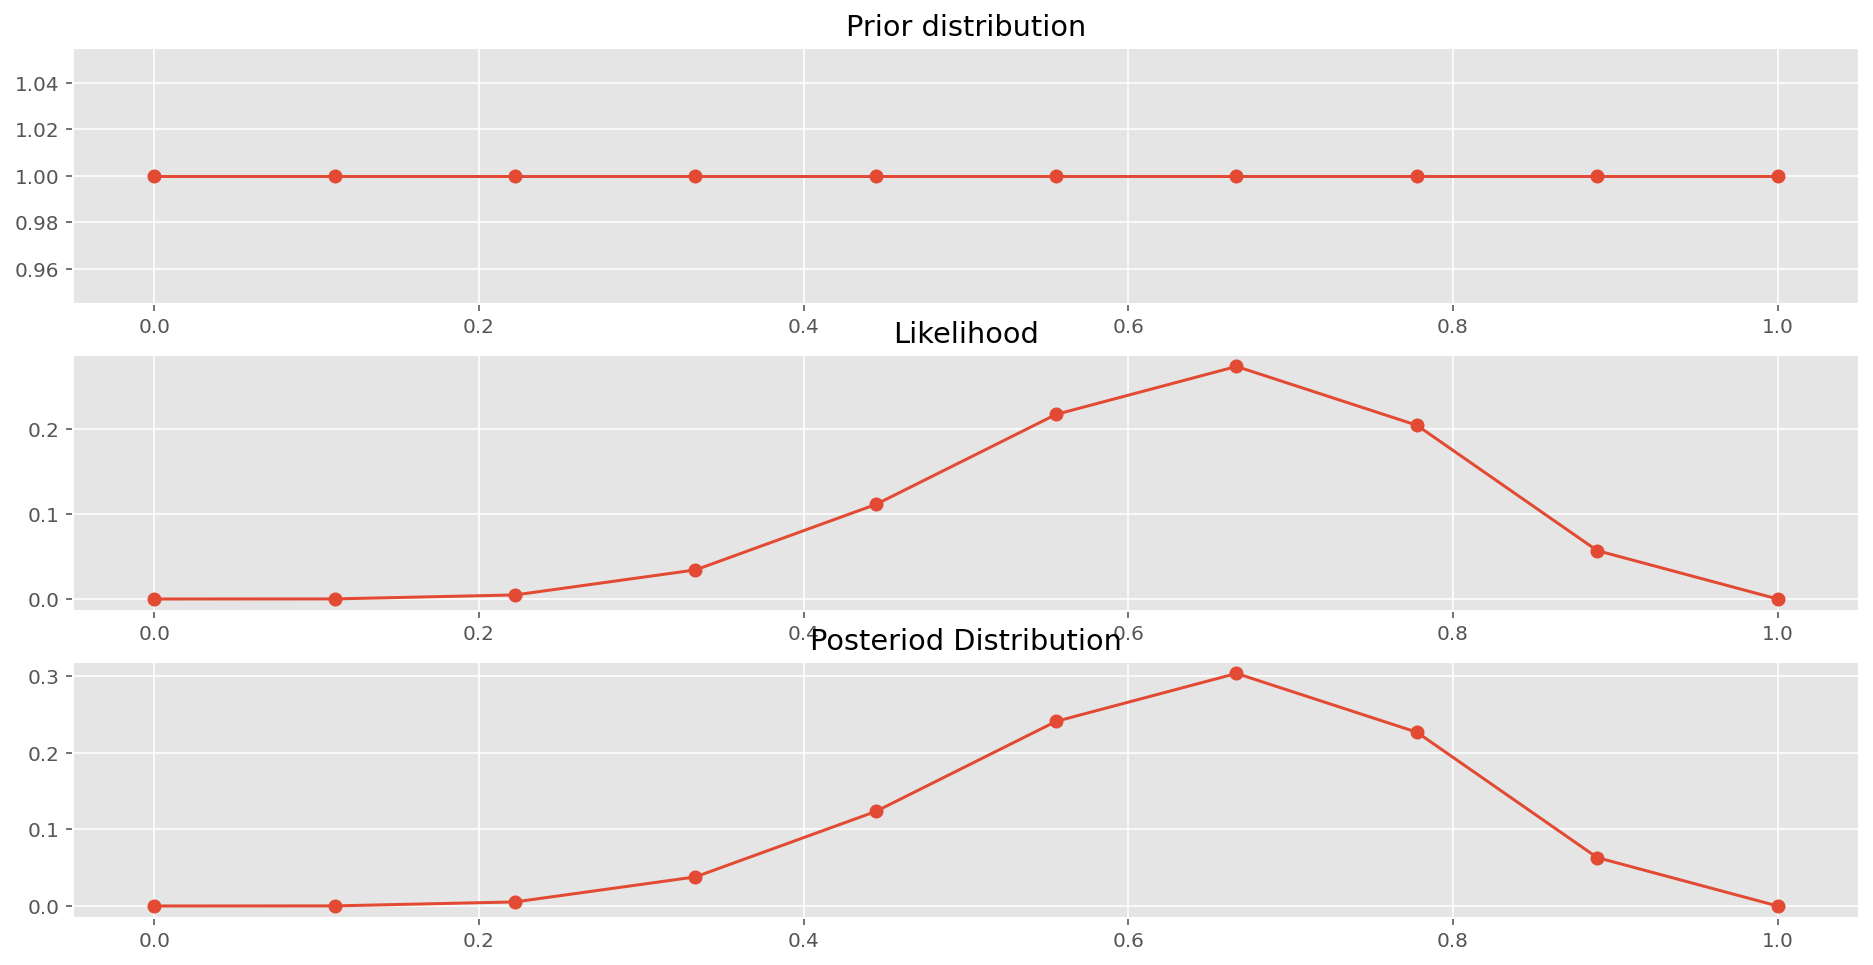

In [7]:
bga = BinomialGridApproximator(X, N, 10, 'uniform')
bga.plot()

In the case of uniform prior, the posteior is equivalent to the likelihood.

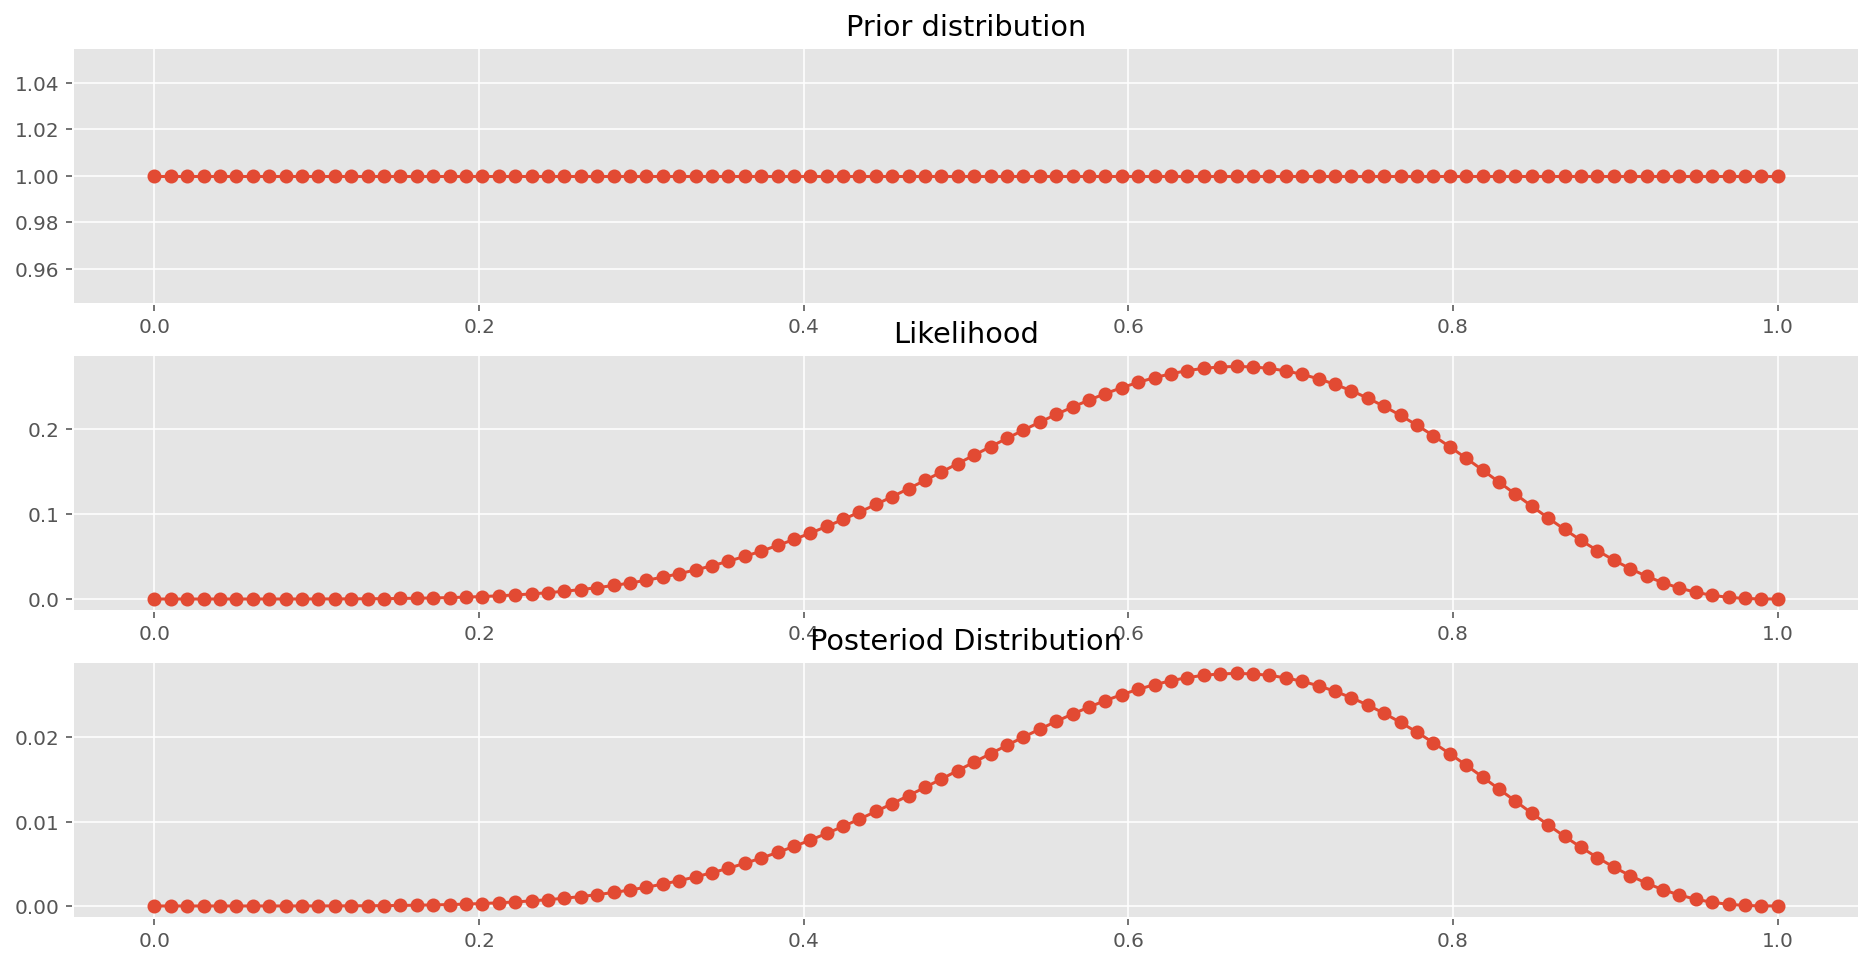

In [8]:
bga = BinomialGridApproximator(X, N, GRID_SIZE, 'uniform')
bga.plot()

The curve/approximation is better with more sample size.

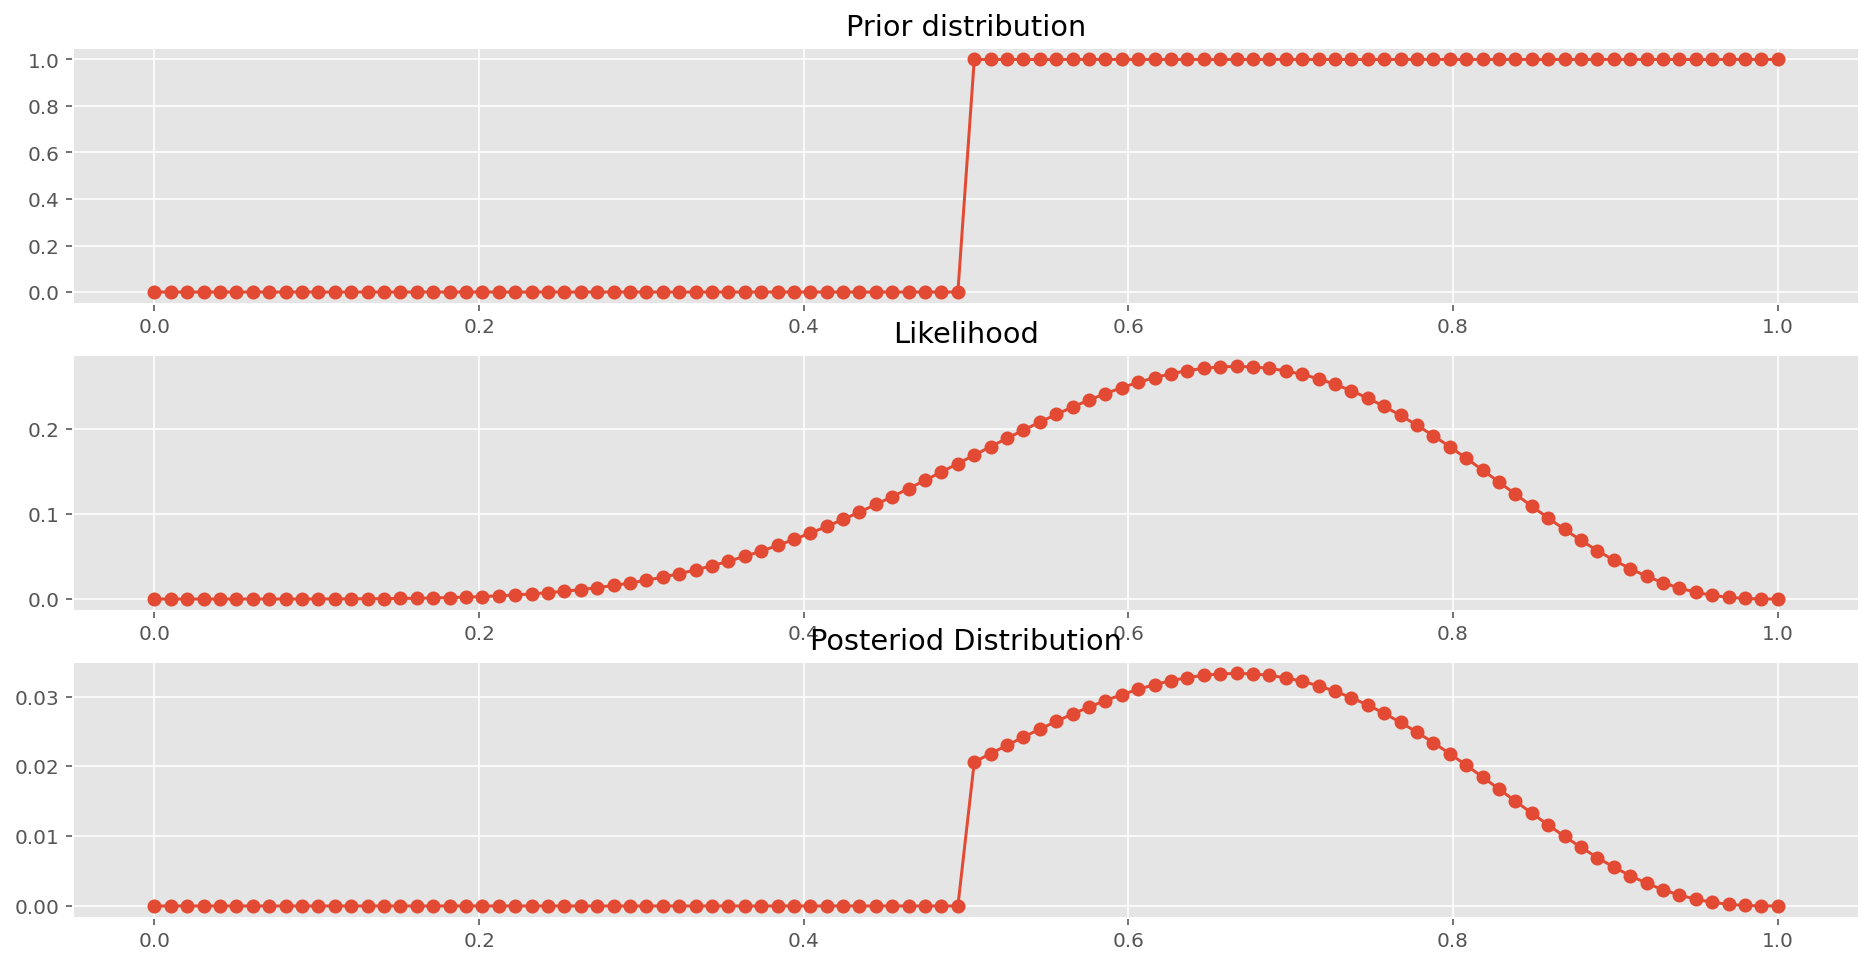

In [9]:
bga = BinomialGridApproximator(X, N, GRID_SIZE, 'positive')
bga.plot()

The posterior is truncated if our prior is strictly positive.

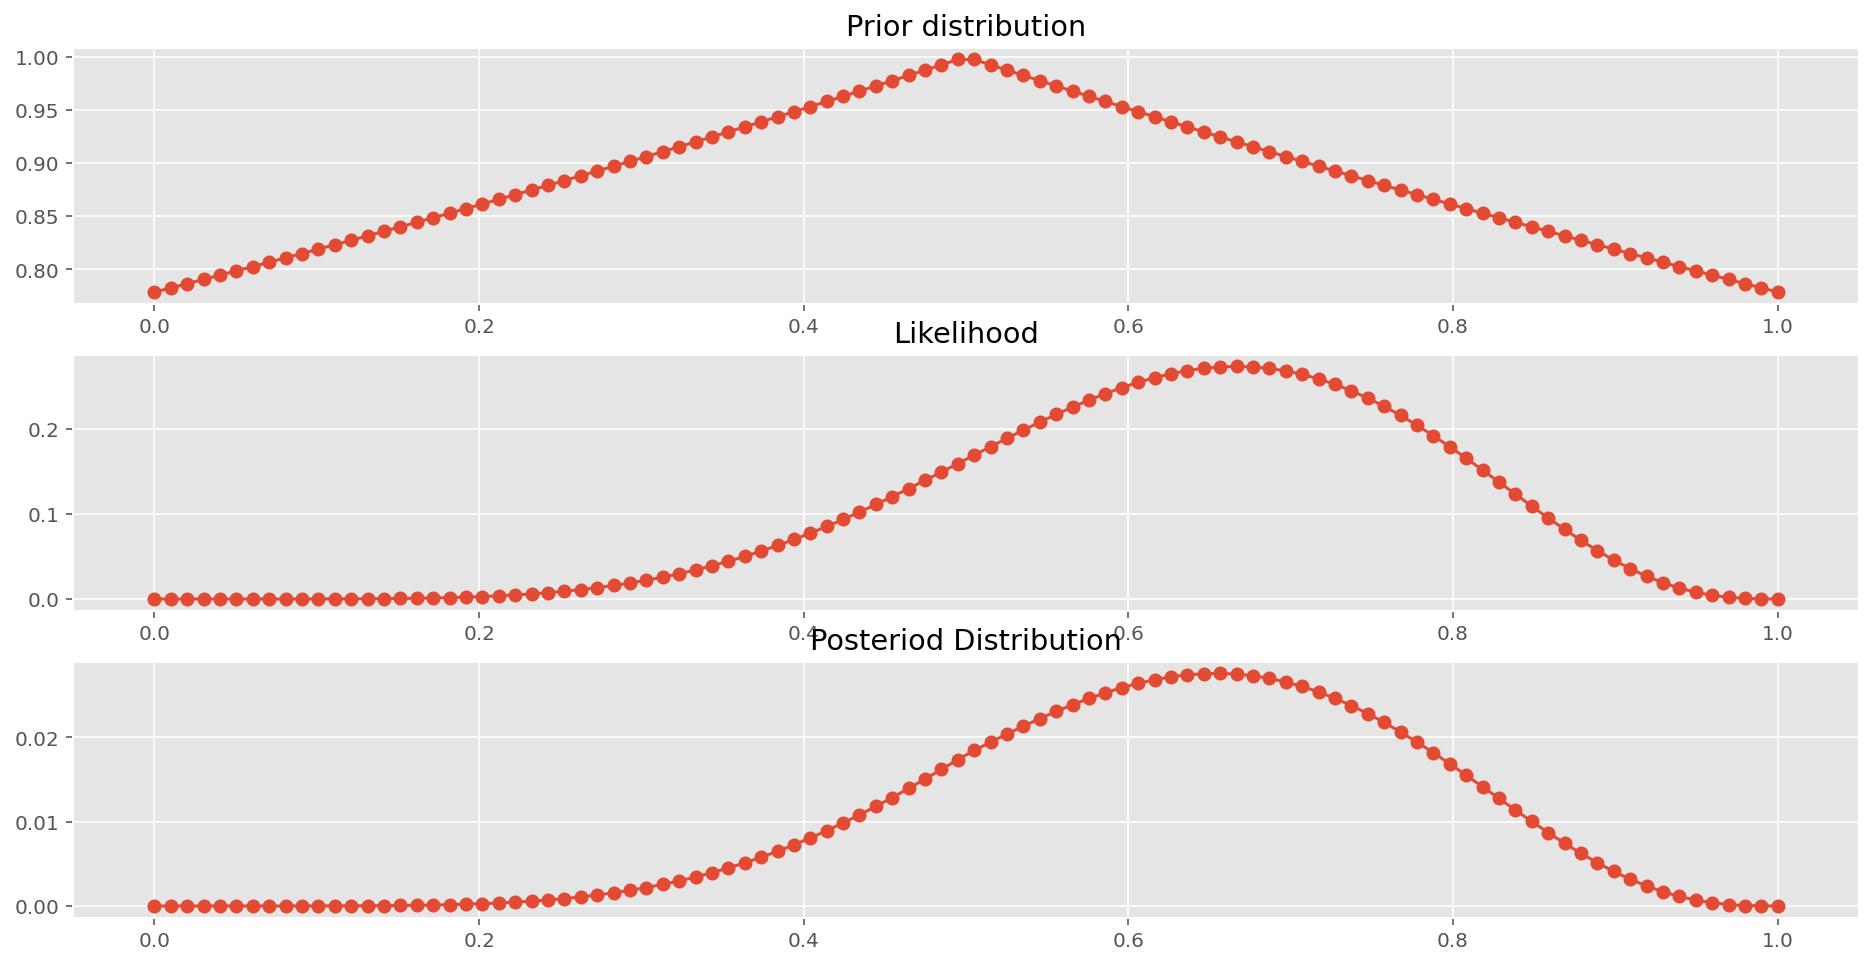

In [10]:
bga = BinomialGridApproximator(X, N, GRID_SIZE, 'laplace')
bga.plot()

This time the prior skewed the likelihood to value closer to 0.5.

# Posterior Estimation via quadratic approximation

The quadratic approximation is inexpensive and attempts to approximate the posterior with a Gaussian distribution with the mean equivalent to the mode of the posterior. The steps are:

1. find the posterior mode.
2. estimate the curvature of the model.

In [11]:
import torch
from src.base import BinomialQuadraticApproximator

x = torch.tensor(6.0)
n = torch.tensor(9.0)

quadratic_approx = BinomialQuadraticApproximator(
    X=x, 
    N=n, 
    n_steps=1000, 
    learning_rate=0.003, 
    prior_type='uniform',
    infer_type='svi')
quadratic_approx.train()


/home/mk/Git/statistical_rethinking_python/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


[iter 0]  loss: 4.1510
[iter 50]  loss: 3.7787
[iter 100]  loss: 3.4857
[iter 150]  loss: 3.2642
[iter 200]  loss: 3.1023
[iter 250]  loss: 2.9878
[iter 300]  loss: 2.9096
[iter 350]  loss: 2.8581
[iter 400]  loss: 2.8253
[iter 450]  loss: 2.8053
[iter 500]  loss: 2.7935
[iter 550]  loss: 2.7868
[iter 600]  loss: 2.7832
[iter 650]  loss: 2.7813
[iter 700]  loss: 2.7803
[iter 750]  loss: 2.7799
[iter 800]  loss: 2.7796
[iter 850]  loss: 2.7795
[iter 900]  loss: 2.7795
[iter 950]  loss: 2.7795


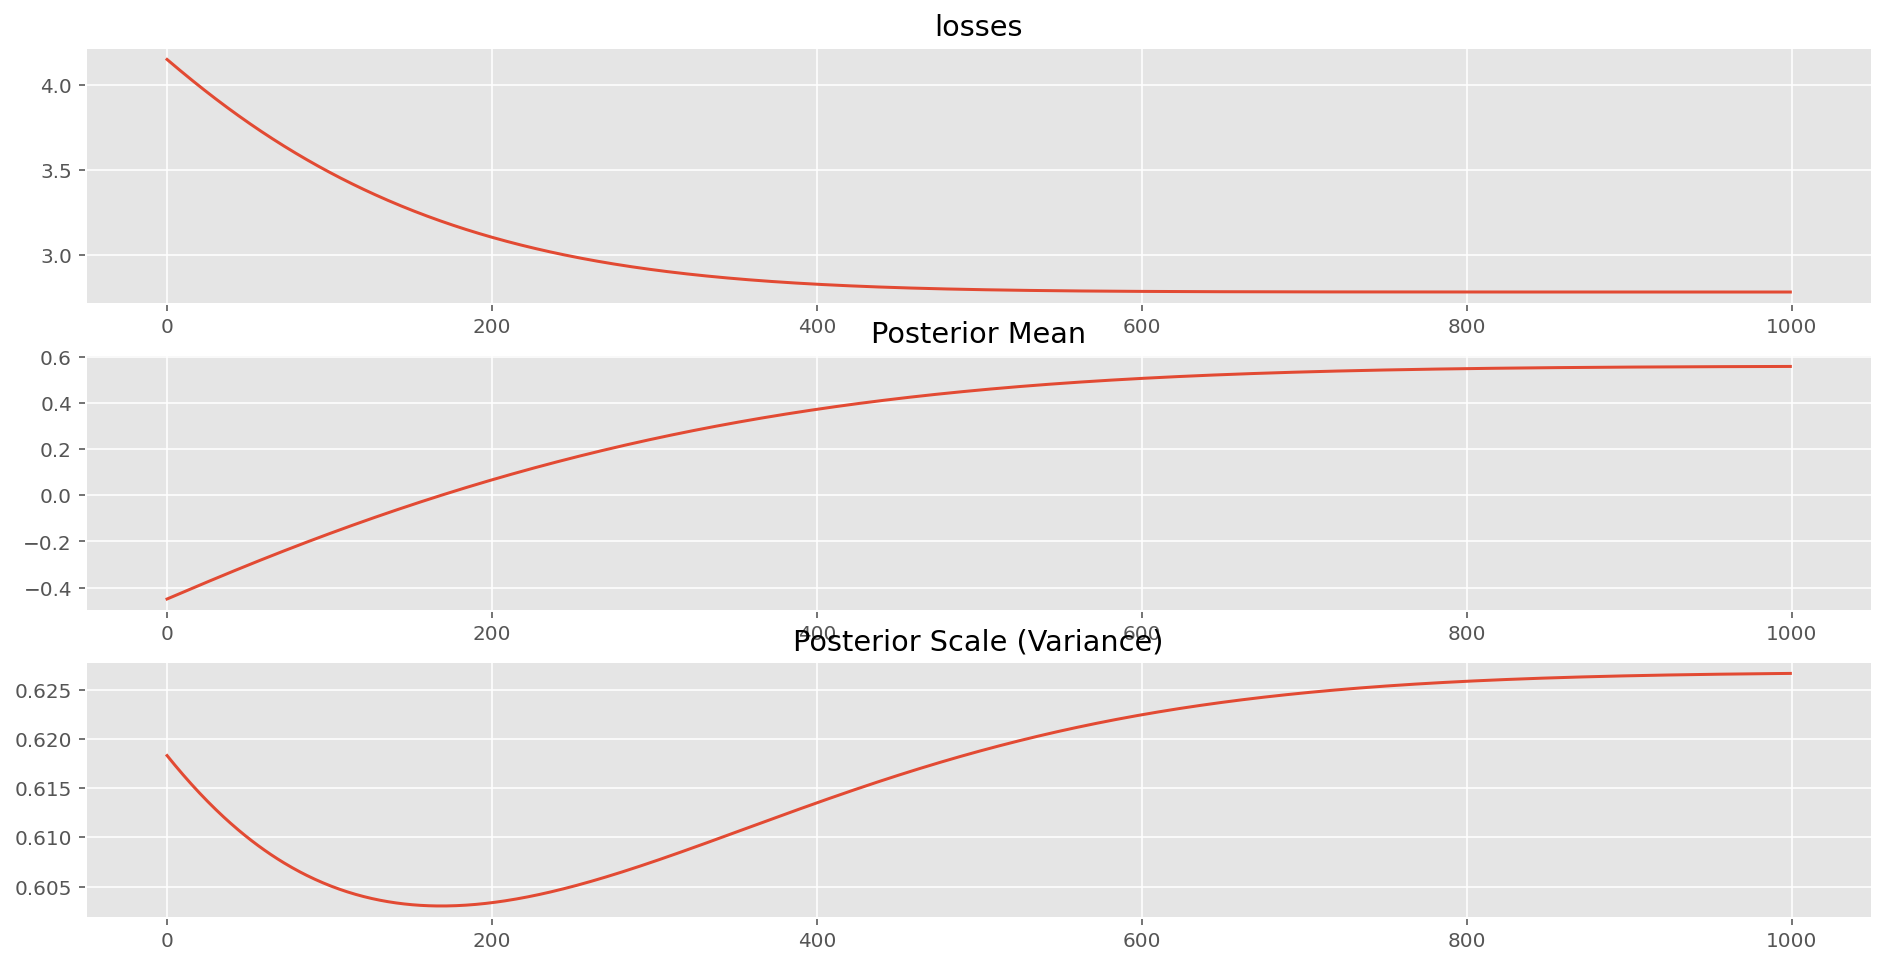

In [12]:
quadratic_approx.plot()

In [13]:
quadratic_approx_beta_prior = BinomialQuadraticApproximator(
    X=x, 
    N=n, 
    n_steps=1000, 
    learning_rate=0.003, 
    prior_type='beta',
    infer_type='svi')
quadratic_approx_beta_prior.train()

[iter 0]  loss: 1.9593
[iter 50]  loss: 1.8077
[iter 100]  loss: 1.7802
[iter 150]  loss: 1.7788
[iter 200]  loss: 1.7788
[iter 250]  loss: 1.7788
[iter 300]  loss: 1.7788
[iter 350]  loss: 1.7788
[iter 400]  loss: 1.7788
[iter 450]  loss: 1.7788
[iter 500]  loss: 1.7788
[iter 550]  loss: 1.7788
[iter 600]  loss: 1.7788
[iter 650]  loss: 1.7788
[iter 700]  loss: 1.7788
[iter 750]  loss: 1.7788
[iter 800]  loss: 1.7788
[iter 850]  loss: 1.7788
[iter 900]  loss: 1.7788
[iter 950]  loss: 1.7788


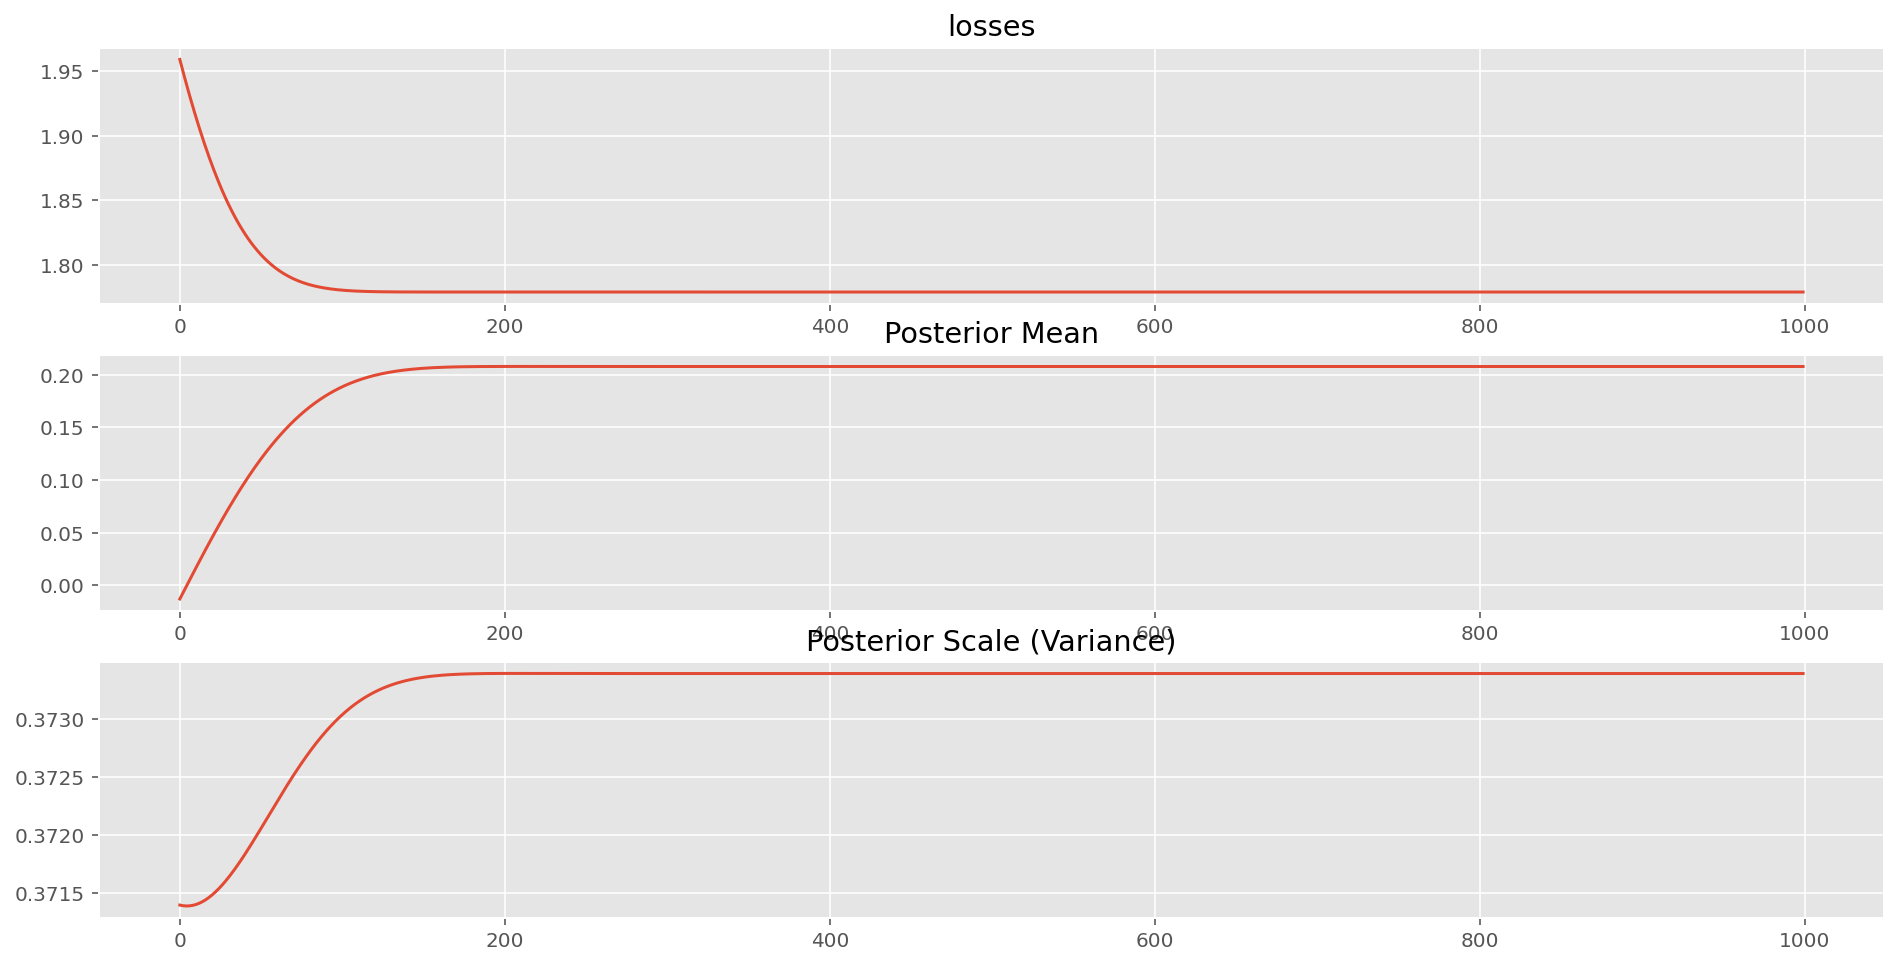

In [14]:
quadratic_approx_beta_prior.plot()

Looks like using the Beta prior converges faster as expected, however, the result is actually wrong compared to the analytical result. We will address this issue later.

In [15]:
quadratic_approx_mcmc = BinomialQuadraticApproximator(
    X=x, 
    N=n, 
    n_steps=1000, 
    learning_rate=0.003, 
    prior_type='uniform',
    infer_type='mcmc')
quadratic_approx_mcmc.train()

Sample: 100%|██████████| 1100/1100 [00:06, 177.95it/s, step size=8.48e-01, acc. prob=0.934]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.63      0.14      0.64      0.38      0.92    467.08      1.00

Number of divergences: 0


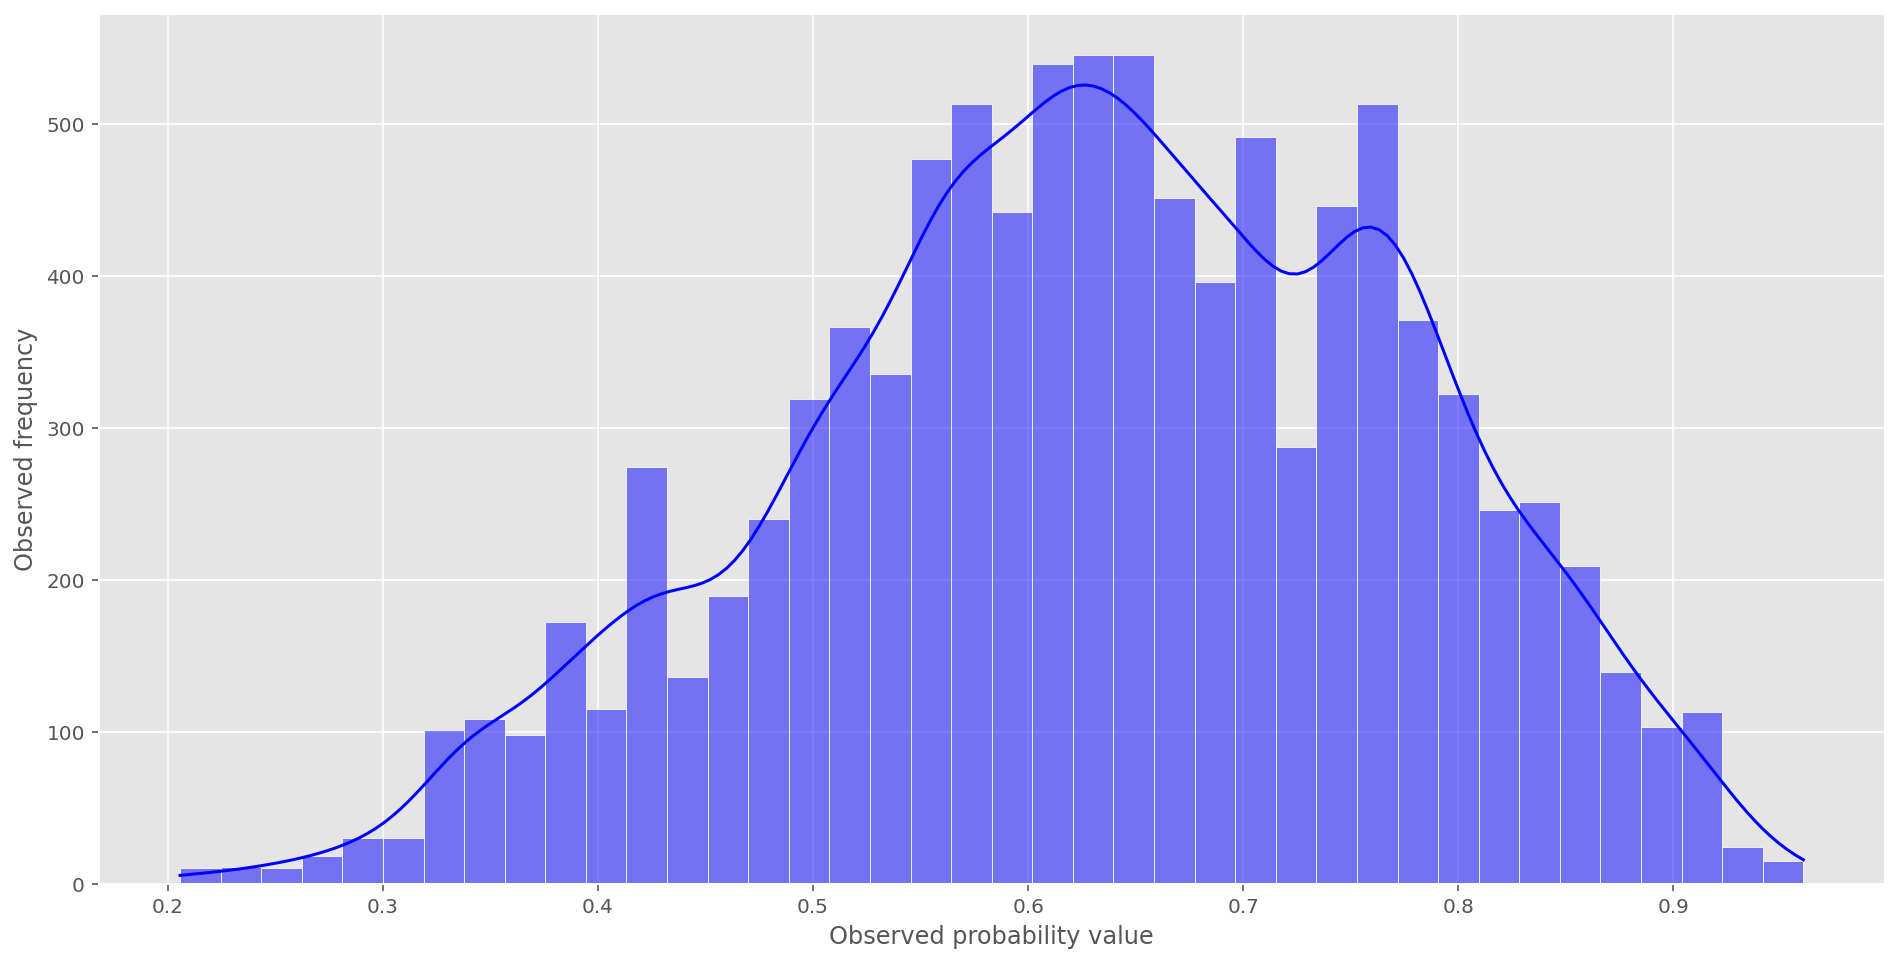

In [16]:
posterior_sample = quadratic_approx_mcmc.mcmc.get_samples(num_samples=10000)
sns.histplot(posterior_sample['p'].numpy(), color='blue', kde=True);
plt.xlabel('Observed probability value')
plt.ylabel('Observed frequency')
quadratic_approx_mcmc.mcmc.summary(prob=0.95)